In [1]:
import os
import numpy as np

from scipy.misc import factorial
from scipy.constants import hbar, h, u
from scipy.special import eval_hermite

from matplotlib import pyplot as plt

cmap = plt.get_cmap('tab20c')

figdir = '../../figure/scale'

os.makedirs(figdir, exist_ok=True)

## Constants

In [103]:
# lattice laser wavelength
λ = 1064e-9

# lattice laser wavenumber
k = 2*np.pi / λ

# lattice constant
a = λ / 2

# cesium mass
m = 133 * u 

# recoil energy
Er = (hbar*k)**2 / (2*m)

Lattice sites are numbered $$-N,-N+1,\dots,-1,0,+1,\dots,+N.$$

Quasi wavenumber is confined to first Brillouin zone and discretized by periodic boundary condition  $$q=\frac{kr}{N},\qquad r\in\left[-N,N-1\right]\cap\mathbb{Z}.$$

In [104]:
# lattice sites
N = 25

# quasi number (q/k)
qk = np.arange(-N, +N) / N
qk

array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
       -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
       -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
        0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
        0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
        0.8 ,  0.84,  0.88,  0.92,  0.96])

### Eigenenergies

Equation (3.31) states

$$H_{st}=\begin{cases}(2s+q/k)^2E_r+\frac{1}{2}V_0, & \text{if } s=t\\\frac{1}{4}V_0, & \text{if } \vert s-t\vert=1\\ 0, & \text{otherwise}\end{cases}$$

for the matrix elements of the energy eigenvalue equation (3.17)

$$E_q\textbf{c}_q=H\textbf{c}_q.$$

The energy eigenvalues have to be found for every $q/k$. The matrix dimensions should be sufficient large.

In [4]:
def hamiltonian(V0, qk, M=60):
    H = np.zeros((M, M, len(qk)))

    for n in range(-M//2, +M//2+1):
        for m in range(-M//2, +M//2+1):
            if n == m:
                H[n, m] = (2*n+qk)**2+.5*V0
            if np.abs(n - m) == 1:
                H[n, m] = .25*V0

    return H

def energies(H):
    E = []

    for n in range(H.shape[-1]):
        eigval, _ = np.linalg.eig(H[:,:,n])
        eigval.sort()
    
        E.append(eigval)
    
    return np.array(E).T

In [93]:
V0 = -np.arange(31)

E = np.array([energies(hamiltonian(V0, qk)) for V0 in V0])

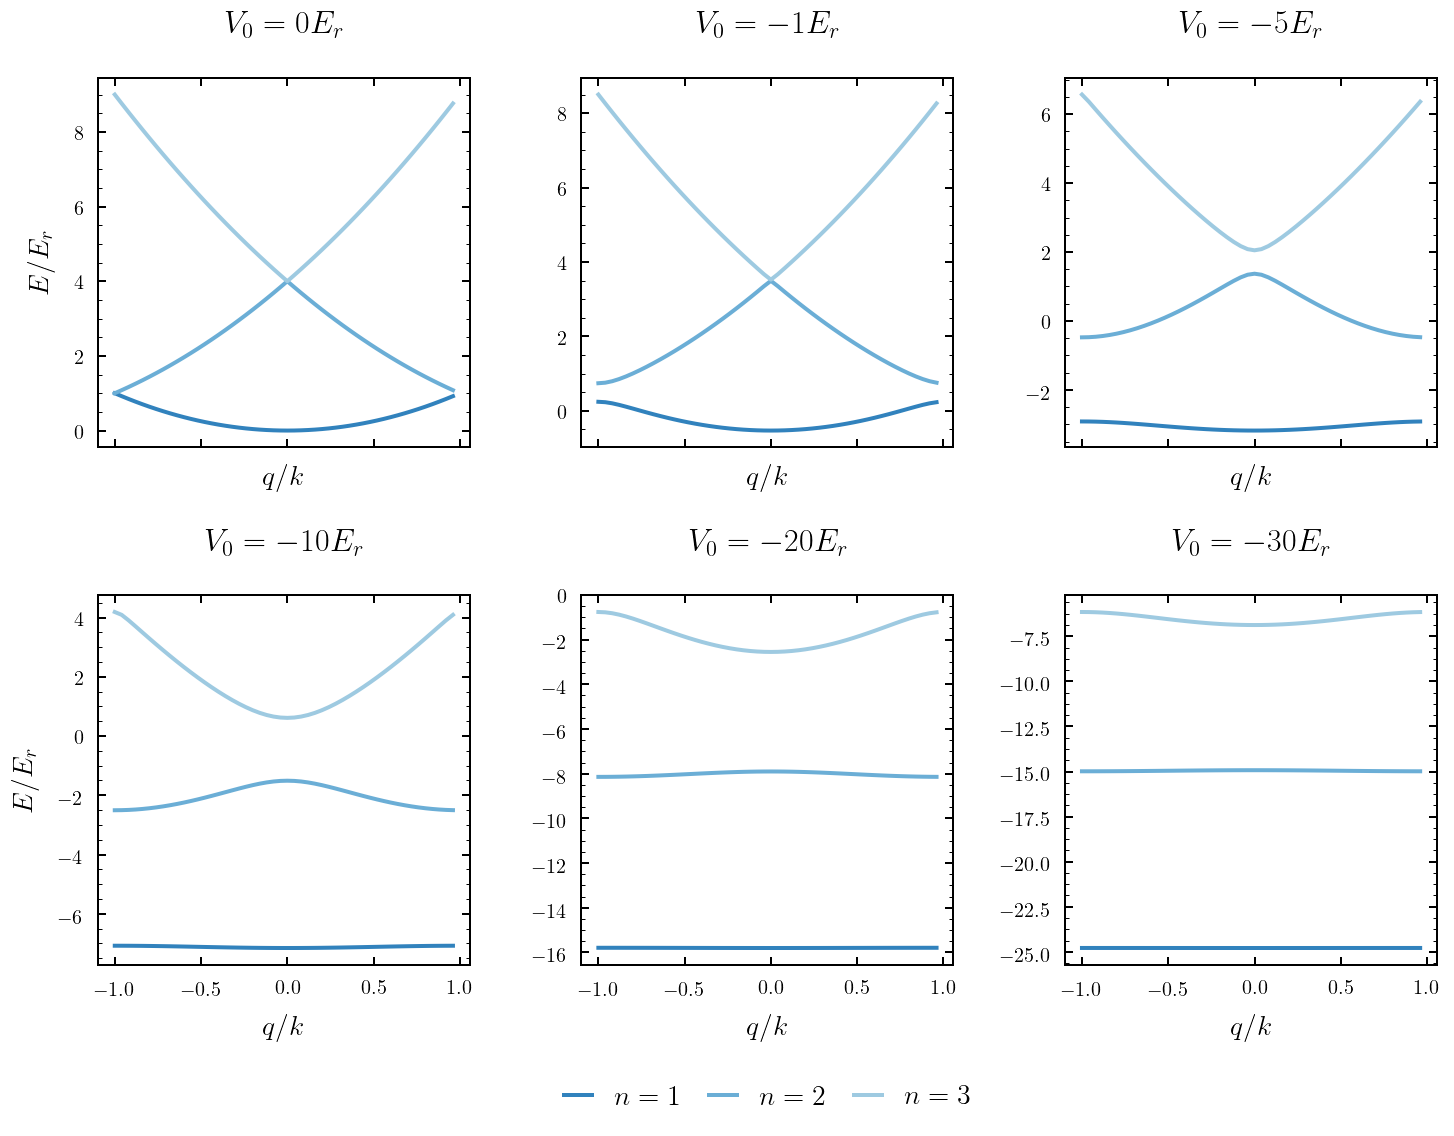

In [94]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), sharex=True)

for i, j in enumerate([0, 1, 5]):
    axes[0][i].set_title(f'$V_0={V0[j]}E_r$')
    axes[0][i].set_xlabel('$q/k$')

    for k in range(3):
        axes[0][i].plot(qk, E[j,k], label=f'$n={k+1}$', color=cmap.colors[k])

for i, j in enumerate([10, 20, 30]):
    axes[1][i].set_title(f'$V_0={V0[j]}E_r$')
    axes[1][i].set_xlabel('$q/k$')

    for k in range(3):
        axes[1][i].plot(qk, E[j,k], label=f'$n={k+1}$', color=cmap.colors[k])

axes[0][0].set_ylabel('$E/E_r$')
axes[1][0].set_ylabel('$E/E_r$')
axes[1][1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)

plt.subplots_adjust(hspace=.4, wspace=.3, top=.92, bottom=.15)
plt.savefig(os.path.join(figdir, 'structure.pdf'))
plt.savefig(os.path.join(figdir, 'structure.pgf'))
plt.show()

## Harmonic Approximation

Taylor expansion of potential:
$$V_0\cos^2\left(kx\right)\approx V_0\left(1-\frac{1}{2}(kx)^2\right)$$

Schrödinger equation:
$$\left(E-V_0\right)\psi=\left(\frac{\hat{p}^2}{2m}-\frac{1}{2}V_0k^2x^2\right)\psi+\left(\frac{\hat{p}^2}{2m}-\frac{1}{2}m\omega^2x^2\right)\psi$$

with angular frequency:
$$\omega=\sqrt{\frac{\vert V_0\vert}{m}}k=\frac{\sqrt{2\vert V_0\vert E_r}}{\hbar}$$

leads to the eigenenergies:
$$E_n=V_0+\sqrt{2\vert V_0\vert E_r}\left(n+\frac{1}{2}\right)$$

In [95]:
E_har = np.zeros(shape=(len(V0), 60), dtype=np.float64)

for i in range(E_har.shape[0]):
    for j in range(E_har.shape[1]):
        E_har[i,j] = V0[i] + np.sqrt(2*np.abs(V0[i]))*(j+1/2)
    
E_har[:5, 0]

array([ 0.        , -0.29289322, -1.        , -1.77525513, -2.58578644])

In [139]:
x = a*np.linspace(-1, +1, 1000)

# gets overwritten before
k = 2*np.pi / λ

V_lat = V0[-1] * np.cos(k*x)**2
V_har = V0[-1] * (1-(k*x/2.2)**2 / 2)

E0_har = np.sqrt(2*np.abs(V0[-1]))

def wavefunction_harmonic(n, x):
    scale = (2 / np.abs(V0[-1]))**(1/4) / k
    
    x = x.copy()
    x /= scale
    
    return np.exp(-x**2 / 2) * eval_hermite(n, x) / np.sqrt(2**n * factorial(n) * np.sqrt(np.pi))

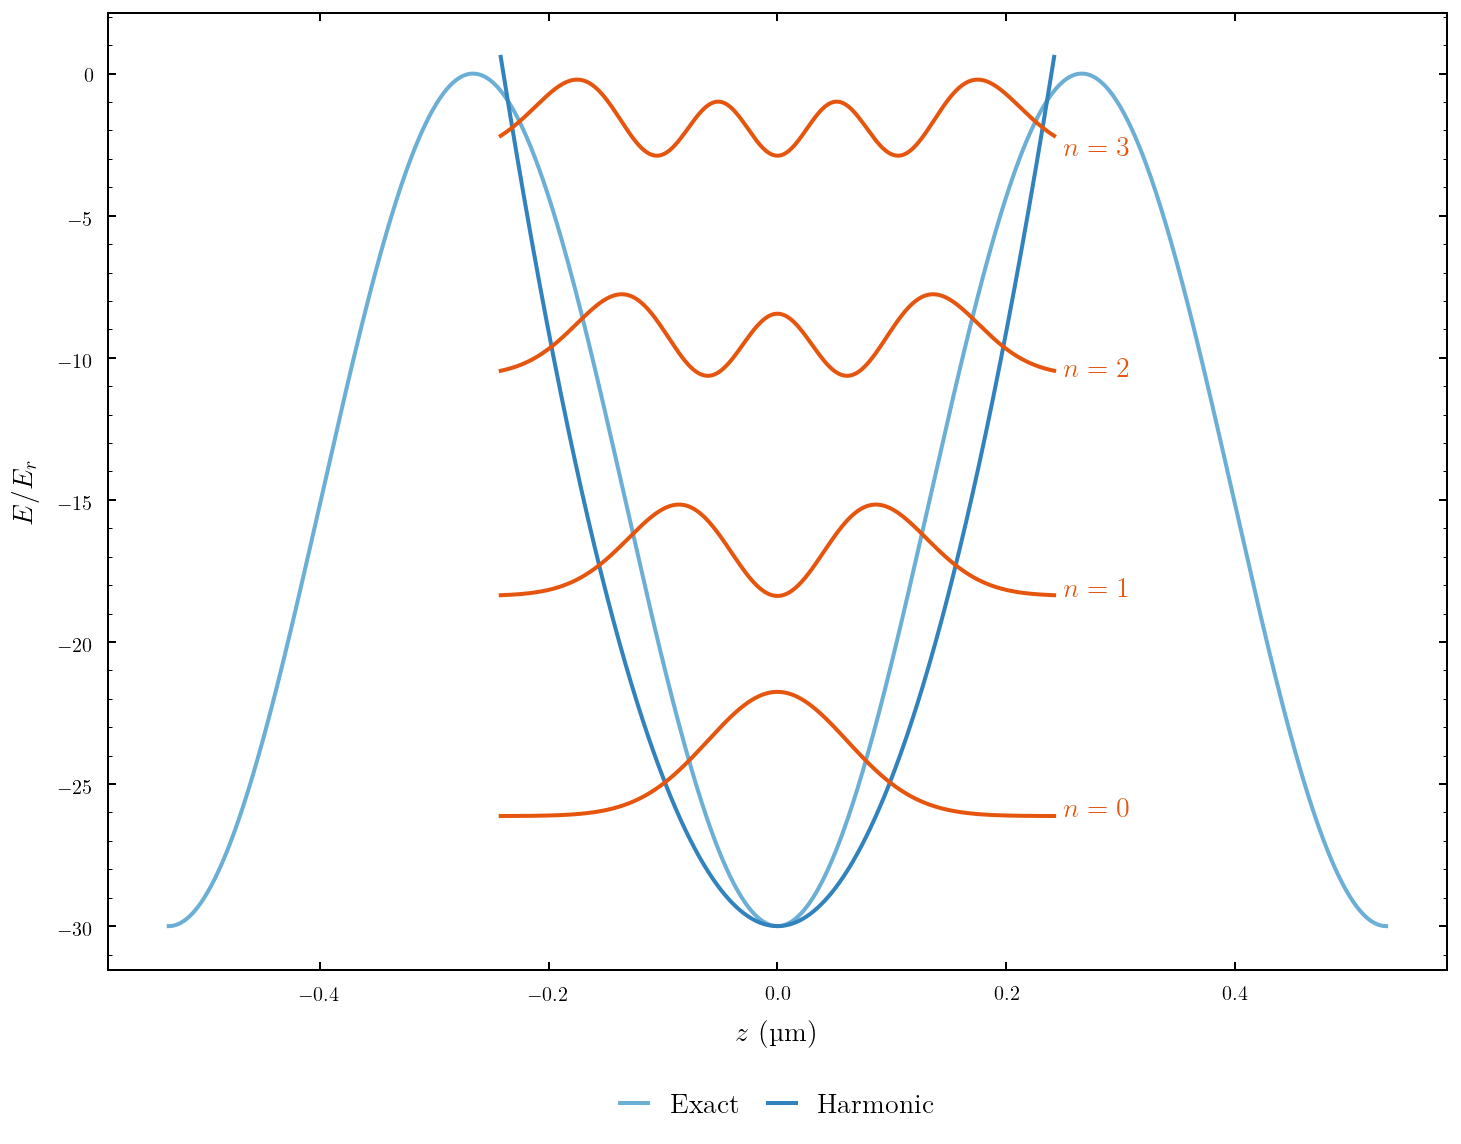

In [169]:
plt.figure(figsize=(12, 8))

plt.plot(x / 1e-6, V_lat, label='Exact', color=cmap.colors[1])
plt.plot(x / 2.2e-6, V_har, label='Harmonic', color=cmap.colors[0])

for n in range(4):
    color = cmap.colors[4]
    
    plt.plot(x / 2.2e-6, V0[-1] + E0_har*(n+.5+wavefunction_harmonic(n, x / 2.2)**2), color=color)
    plt.annotate(f'$n={n}$', (.25, V0[-1]+E0_har*(n+.5)), color=color, size=14)

plt.xlabel('$z$ (\si{\micro\meter})')
plt.ylabel('$E/E_r$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.subplots_adjust(top=.98, bottom=.15)
plt.savefig(os.path.join(figdir, 'harmonic.pdf'))
plt.savefig(os.path.join(figdir, 'harmonic.pgf'))
plt.show()

In [148]:
E0_har

7.745966692414834

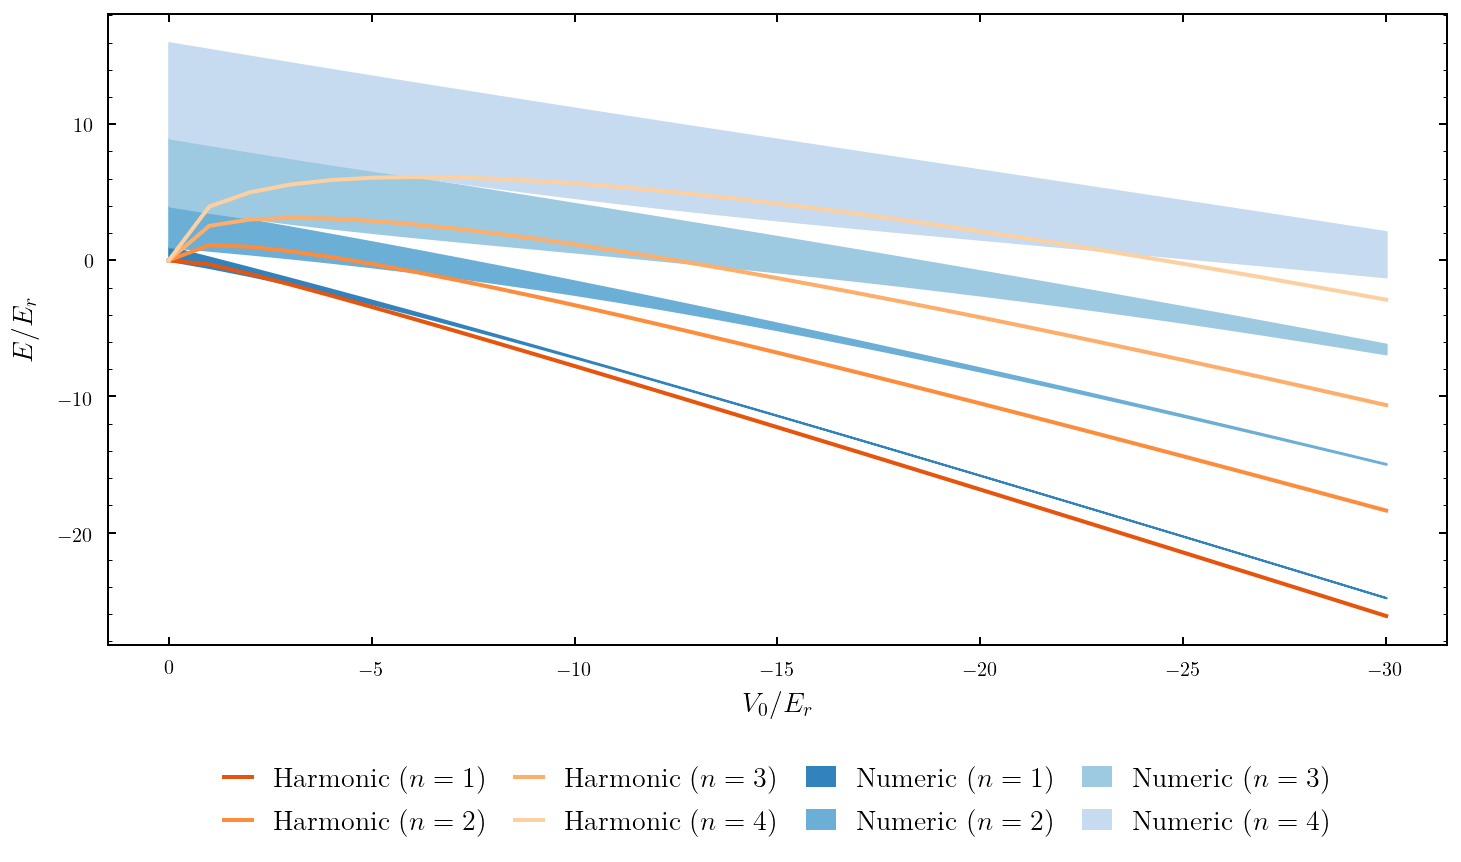

In [32]:
plt.figure(figsize=(12, 6))

for i in range(4):
    y1 = E[:,i].min(axis=1)
    y2 = E[:,i].max(axis=1)

    plt.fill_between(V0, y1, y2, label=f'Numeric ($n={i+1}$)', color=cmap.colors[i])
    
for i in range(4):
    plt.plot(V0, E_har[:,i], label=f'Harmonic ($n={i+1}$)', color=cmap.colors[i+4])
    
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

plt.xlabel('$V_0/E_r$')
plt.ylabel('$E/E_r$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.subplots_adjust(top=.98, bottom=.25)

plt.savefig(os.path.join(figdir, 'energy.pdf'))
plt.savefig(os.path.join(figdir, 'energy.pgf'))
plt.show()

## Hopping

### Nearest Neighbour

Hopping is only permitted between nearest neighbours. Form from eq. (3.26) with $l-l^\prime=1$:
$$J^n_1=\frac{1}{N}\sum_q E^n_q e^{iqa}.$$

#### Tight-Binding

Hopping only permitted at boundaries of Brillouin zone. $$J^n_1\approx\frac{E^n_k-E^n_0}{4}$$

#### Analytical Proxmity

Known from literature. Only valid for first energy band.
$$J^1_1\approx\frac{4}{\sqrt{\pi}}\left(\frac{V_0}{E_r}\right)^{3/4}\exp\left(-2\sqrt{V_0/E_r}\right)$$

In [33]:
def hopping_nn_tight(E):
    return (E.max(axis=E.ndim-1) - E.min(axis=E.ndim-1)) / 4

def hopping_nn_exact(E, dl=1):
    return np.dot(E, np.exp(1j*np.pi*qk*dl)) / (2*N+1)

def hopping_nn_proximity(V0):
    return 4 * np.abs(V0)**(3/4) * np.exp(-2*np.sqrt(np.abs(V0))) / np.sqrt(np.pi) 

In [34]:
J_nn_ex = np.abs(hopping_nn_exact(E))
J_nn_tb = np.abs(hopping_nn_tight(E))
J_nn_pr = np.abs(hopping_nn_proximity(V0))

# 1. energy band for V_0=-10E_r
J_nn_ex[10,0], J_nn_tb[10,0], J_nn_pr[10]

(0.0188063256345387, 0.019186709053235385, 0.022738697223236362)

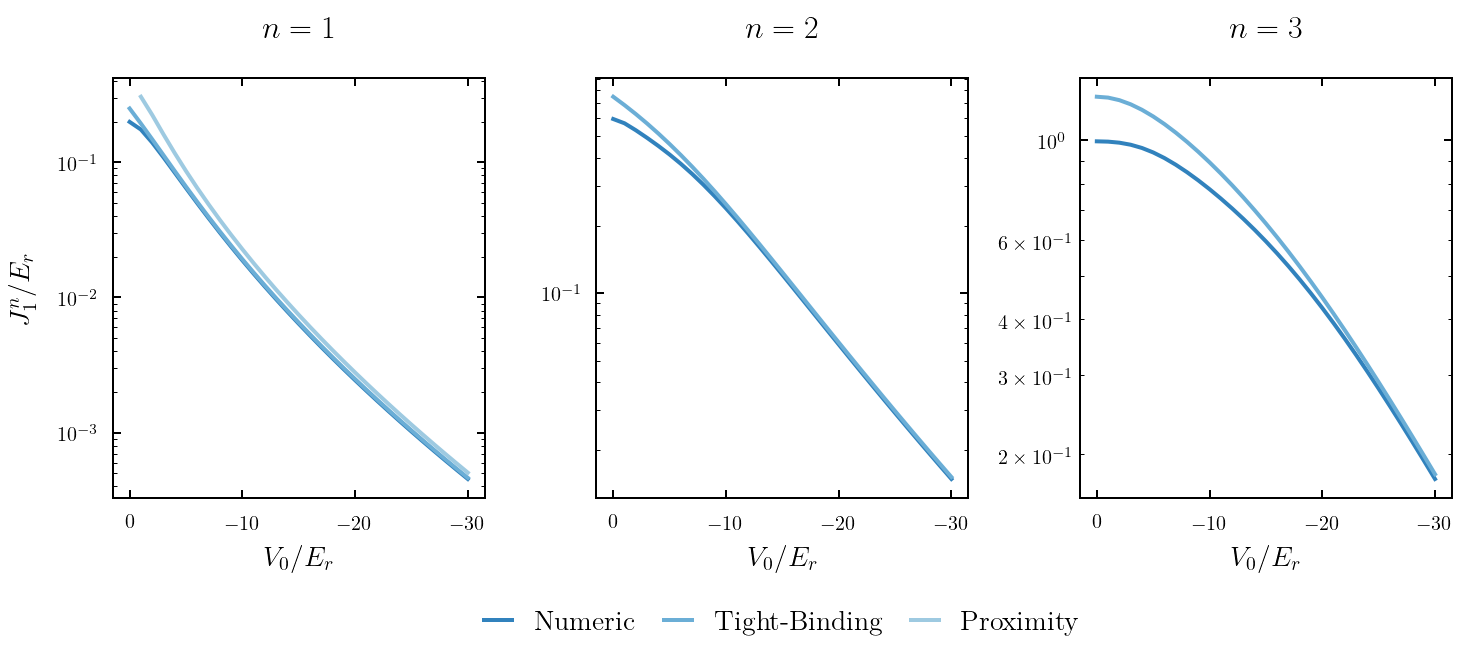

In [53]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

axes[0].set_title('$n=1$')
axes[0].set_xlabel('$V_0/E_r$')
axes[0].plot(V0, J_nn_ex[:,0], label='Numeric', color=cmap.colors[0])
axes[0].plot(V0, J_nn_tb[:,0], label='Tight-Binding', color=cmap.colors[1])
axes[0].plot(V0[1:], J_nn_pr[1:], label='Proximity', color=cmap.colors[2])
axes[0].set_xlim(axes[0].get_xlim()[::-1])
axes[0].set_yscale('log')

axes[1].set_title('$n=2$')
axes[1].set_xlabel('$V_0/E_r$')
axes[1].plot(V0, J_nn_ex[:,1], label='Exact', color=cmap.colors[0])
axes[1].plot(V0, J_nn_tb[:,1], label='Tight-Binding', color=cmap.colors[1])
axes[1].set_xlim(axes[1].get_xlim()[::-1])
axes[1].set_yscale('log')

axes[2].set_title('$n=3$')
axes[2].set_xlabel('$V_0/E_r$')
axes[2].plot(V0, J_nn_ex[:,2], label='Exact', color=cmap.colors[0])
axes[2].plot(V0, J_nn_tb[:,2], label='Tight-Binding', color=cmap.colors[1])
axes[2].set_xlim(axes[2].get_xlim()[::-1])
axes[2].set_yscale('log')

axes[0].legend(loc='upper center', bbox_to_anchor=(1.8, -0.2), ncol=3)
axes[0].set_ylabel('$J^n_1/E_r$')

plt.subplots_adjust(hspace=.4, wspace=.3, top=.98, bottom=.25)
plt.savefig(os.path.join(figdir, 'hopping-nn.pdf'))
plt.savefig(os.path.join(figdir, 'hopping-nn.pgf'))
plt.show()

### All neighbours

As our potential will involve a patch of the global lattice we are interested in the total hopping energy
$$\sum^N_{l-l^\prime=1}J^n_{l-l^\prime}.$$

In [45]:
def hopping_exact(E):
    return np.sum([hopping_nn_exact(E, dl) for dl in range(1, N+1)], axis=0)

In [46]:
J_1 = hopping_nn_exact(E, 1)
J_2 = hopping_nn_exact(E, 2)
J_3 = hopping_nn_exact(E, 3)
J_4 = hopping_nn_exact(E, 4)
J = hopping_exact(E)

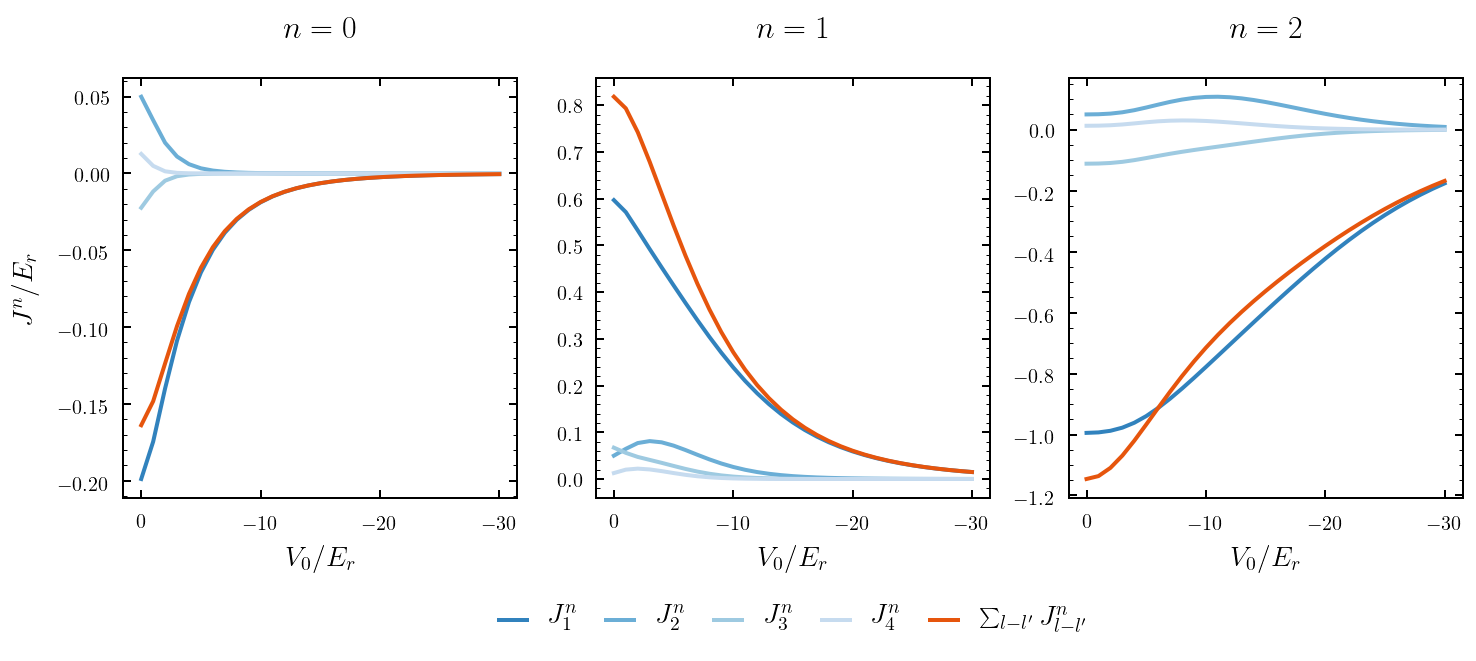

In [54]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for i in range(3):
    axes[i].set_title(f'$n={i}$')
    axes[i].set_xlabel('$V_0/E_r$')
    axes[i].plot(V0, J_1[:,i], label='$J^n_1$', color=cmap.colors[0])
    axes[i].plot(V0, J_2[:,i], label='$J^n_2$', color=cmap.colors[1])
    axes[i].plot(V0, J_3[:,i], label='$J^n_3$', color=cmap.colors[2])
    axes[i].plot(V0, J_4[:,i], label='$J^n_4$', color=cmap.colors[3])
    axes[i].plot(V0, J[:,i], label=r'$\sum_{l-l^\prime}J^n_{l-l^\prime}$', color=cmap.colors[4])
    axes[i].set_xlim(axes[i].get_xlim()[::-1])

axes[1].legend(loc='upper center', bbox_to_anchor=(.5, -0.2), ncol=5)
axes[0].set_ylabel('$J^n/E_r$')

plt.subplots_adjust(hspace=.4, wspace=.2, top=.98, bottom=.25)
plt.savefig(os.path.join(figdir, 'hopping.pdf'))
plt.savefig(os.path.join(figdir, 'hopping.pgf'))
plt.show()

## Conclusion

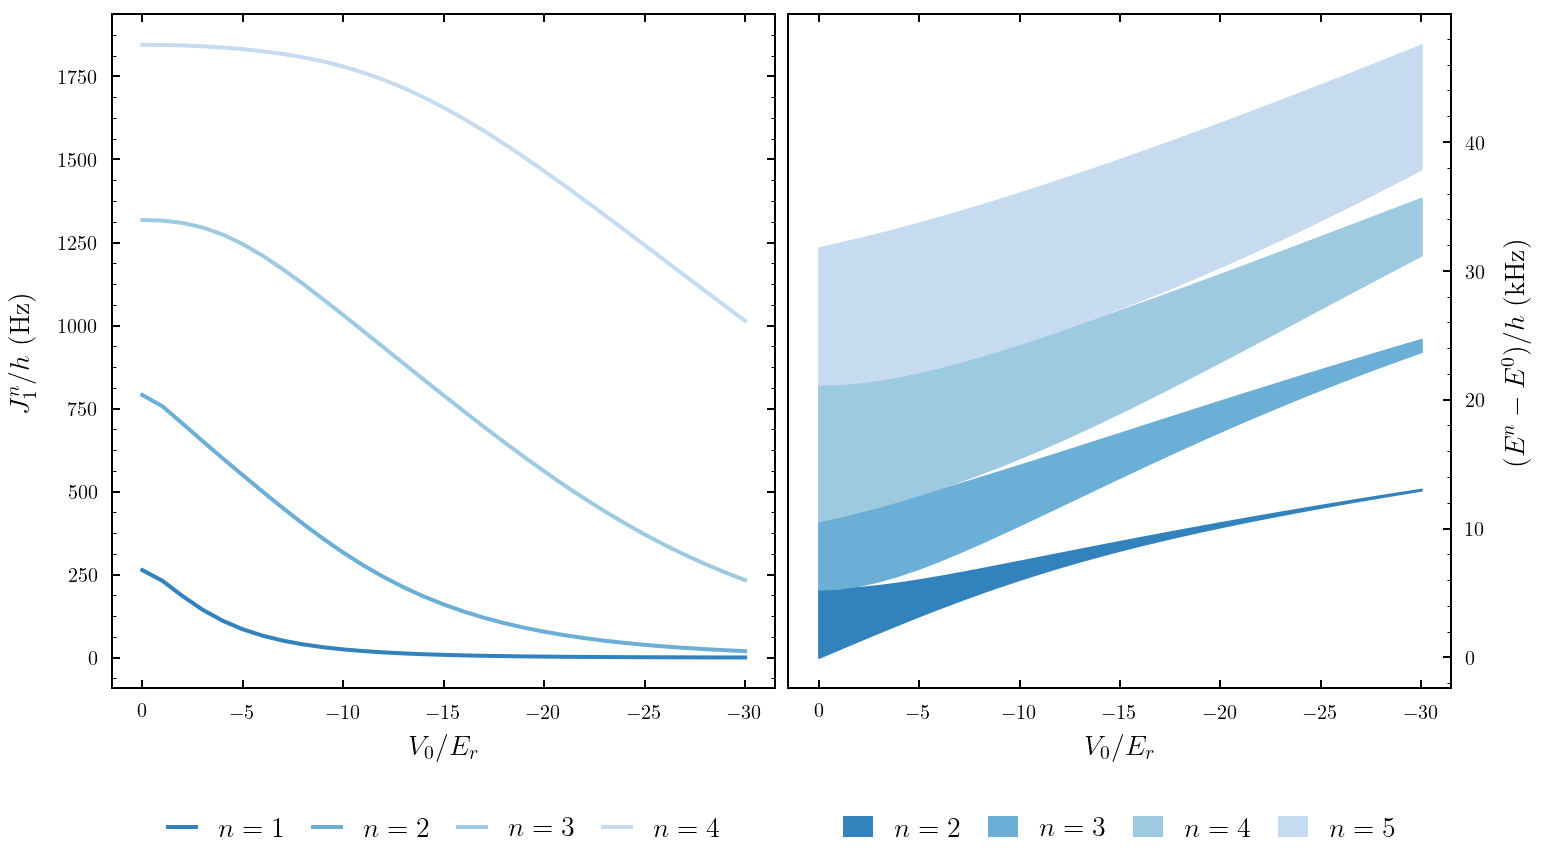

In [170]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

for i in range(4):
    axes[0].plot(V0, np.abs(J_1[:,i]) * Er / h, label=f'$n={1+i}$', color=cmap.colors[i])

axes[0].set_xlabel('$V_0/E_r$')
axes[0].set_ylabel('$J^n_1/h$ (\si{\hertz})')
axes[0].set_xlim(axes[0].get_xlim()[::-1])


for i in range(1, 5):
    y1 = (E[:,i]-E[:,0]).min(axis=1) * Er / h
    y2 = (E[:,i]-E[:,0]).max(axis=1) * Er / h
    
    axes[1].fill_between(V0, y1 / 1e3, y2 / 1e3, label=f'$n={i+1}$', color=cmap.colors[i-1])

axes[1].set_xlabel('$V_0/E_r$')
axes[1].set_ylabel('$(E^n-E^0)/h$ (\si{\kilo\hertz})')
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
axes[1].set_xlim(axes[1].get_xlim()[::-1])
                 
axes[0].legend(loc='upper center', bbox_to_anchor=(.5, -0.15), ncol=4)
axes[1].legend(loc='upper center', bbox_to_anchor=(.5, -0.15), ncol=4)

plt.subplots_adjust(hspace=.4, wspace=.02, top=.98, bottom=.2)
plt.savefig(os.path.join(figdir, 'frequency.pdf'))
plt.savefig(os.path.join(figdir, 'frequency.pgf'))
plt.show()